<a href="https://colab.research.google.com/github/krislars/R-uncertainty/blob/master/MonteCarloModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
import random
import numpy as np
import numpy.random as npRand
from matplotlib import pyplot as plt
import scipy.stats as stats

In [37]:
%matplotlib inline

Data file format is intrinsic stellar H-K, sigma H-K, J-H, sigma J-H ... 
Davenport, J. R., Ivezic, Z., Becker, A. C., Ruan, J. J., Hunt-Walker, N. M., Covey, K. R., & Lewis, A. R. (2014, June). The SDSS-2MASS-WISE 10-dimensional stellar colour locus [Electronic version]. MNRAS, 440(4), 3430-3438.

In [38]:
starData = np.loadtxt("https://raw.githubusercontent.com/krislars/R-uncertainty/master/Astro%20Lab%20Star%20Data.txt")
starData = np.transpose(starData)
B, dB = starData[0], starData[1]
D, dD = starData[2], starData[3]

This next line is propagation of error in an arithmetic function.

In [39]:
#calculating theoretical dR
dR = 1.6 *(dB**2 + .02**2 + 1.6 *(dD**2 + .02**2))**0.5

This function takes a vector of values and a vector of associated uncertainties and returns an array of n = numVals samples selected randomly from a normal  probability distribution.

In [40]:
#choosing random data sets for each star type
def getData(mean, sigma, numVals):
    data = np.array(
        [npRand.normal(m, s, numVals) for m, s in zip(mean, sigma)]
    )
    return data

In [41]:
B_vals = getData(B, dB, 1000)
D_vals = getData(D, dB, 1000)

$$
R = \frac{A-B}{C-D}
$$

We will choose values such that the numerator is 1.  So, $A=1+B$.  We also choose the value of R to be 1.6, so $C-D=1/1.6$.  Therefore, $C = 1/1.6+D$.



In [42]:
A = 1 + B
C = 1/1.6 + D
dA = dC = np.linspace(0.02, 0.02, 50)
A_vals = getData(A, dA, 1000)
C_vals = getData(C, dC, 1000)

In [43]:
#calculating the "Monte Carlo" values for R and dR
R_vals = (A_vals - B_vals) / (C_vals - D_vals)


Now, we can test the distributions of R.

In [44]:
R_mc = np.mean(R_vals, axis=1)
dR_mc = np.std(R_vals, axis=1)

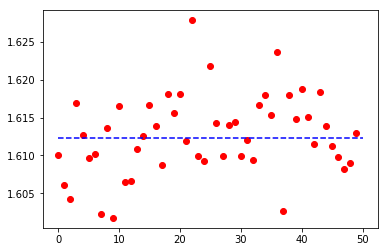

In [46]:
#Finding the weighted average of R
dR_mean = (dR_mc) / (1000)**0.5
w = (dR_mean)**(-2)
R_avg = sum(w*R_mc) / sum(w)

t = np.linspace(0, 50, 200)
y = np.linspace(R_avg, R_avg, 200)

plt.plot(R_mc,'ro', t, y, 'b--')

Ideas going forward:
* Calculate the uncertainty in the mean.
* Try a weighted mean
* Try making all the errors the same
* Try making the errors very small
* Test that you are resetting the random number *seed* 



In [20]:
#Next I need to test "Goodness of fit"
numBins = 20
counts, Bins = zip(*np.stack(
    np.histogram(r_vals, numBins) for r_vals in R_vals
))
    

#calc expected with stats cdf and np.diff
exp = np.diff(np.stack(
    stats.norm.cdf(bins, r_mc, dr_mc) for bins, r_mc, dr_mc in zip(Bins, R_mc, dR_mc)
))

#scale expected percentages by sample size
exp = 1000 * exp

#Now calculate the Chi^2 values:
chi2 = np.sum(( (counts - exp)**2 / exp), axis=1)


In [21]:
chi2/numBins

array([ 0.76176628,  3.4348463 ,  1.05782545,  1.97531645,  1.96874517,
        1.55229112,  1.83214328,  1.5952379 ,  1.1522778 ,  7.31462426,
        2.77568625,  1.15923502,  1.60659985,  1.77202111,  1.62075879,
        1.61328614,  2.57184512,  1.98500509,  0.84762083,  2.94213374,
        1.24773386,  1.54913256,  1.12993621,  1.52295318,  2.37438805,
        1.07982227,  1.16032063,  1.83825116,  1.3752723 ,  1.4722482 ,
        2.18951452,  1.64945568, 21.91207288,  1.90489469,  1.03774201,
        1.66315821,  0.9782286 ,  2.11913025,  1.39886444,  0.78343862,
        0.90122863,  1.93534642,  0.72376068, 17.20875256,  1.63433757,
        3.6241004 ,  1.08853745,  1.32462357,  1.03686613,  1.30621802])